# OSM 2024 figures notebook

***

In [1]:
import numpy as np
import xarray as xr
import yaml
import sys
from matplotlib import pyplot as plt, patches
from cartopy import crs, feature
from datetime import datetime
from tqdm import tqdm

from shapely.geometry import Polygon
from shapely.ops import unary_union

# Import modules from path
sys.path.append('../modules/')
import calc_transformation_budget as trtools
import watermasstools as wmttools

plt.rcParams.update({'font.size': 11, 'axes.titlesize': 'medium'})

***

### AMOC figures

In [2]:
# Load MOC streamfunction Atlantic subregion from LR and HR results archive
MOC = {'LR': {}, 'HR': {}}
for meshName in MOC:

    # Get paths
    with open(f'../yaml/paths_{meshName}.yaml') as f:
        paths = yaml.safe_load(f)

    # Get bottom depth array
    with xr.open_dataset(paths['meshfile']) as ds:
        MOC[meshName]['refBottomDepth'] = ds.refBottomDepth.values

    # Loop through decades
    for decade in [('1947-1957'), ('1957-1967'), ('1997-2007')]:

        # Startyear and results prefix string
        startyear = int(decade.split('-')[0]) - 1946
        resultsprefix = paths['results'][decade] + '/' + paths['prefix']

        # Loop through years and months
        MOC[meshName][decade], latitude = {'MOC': []}, None
        for year in tqdm(range(startyear, startyear+10), desc=f'Loading {meshName} over {decade}'):
            for month in range(1, 13):

                # Open results file
                try:
                    with xr.open_dataset(resultsprefix + f'.{year:04d}-{month:02d}-01.nc') as ds:

                        if latitude is None:
                            MOC[meshName][decade]['lat'] = np.rad2deg(ds.binBoundaryMocStreamfunction.values)

                        MOC[meshName][decade]['MOC'].append(ds.timeMonthly_avg_mocStreamvalLatAndDepthRegion[0, 0, ...])
                except:
                    nan = np.full(MOC[meshName][decade]['MOC'][-1].shape, np.nan)
                    MOC[meshName][decade]['MOC'].append(nan)
        
        # Concatenate lists
        MOC[meshName][decade]['MOC'] = np.array(MOC[meshName][decade]['MOC'])

Loading HR over 1997-2007: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


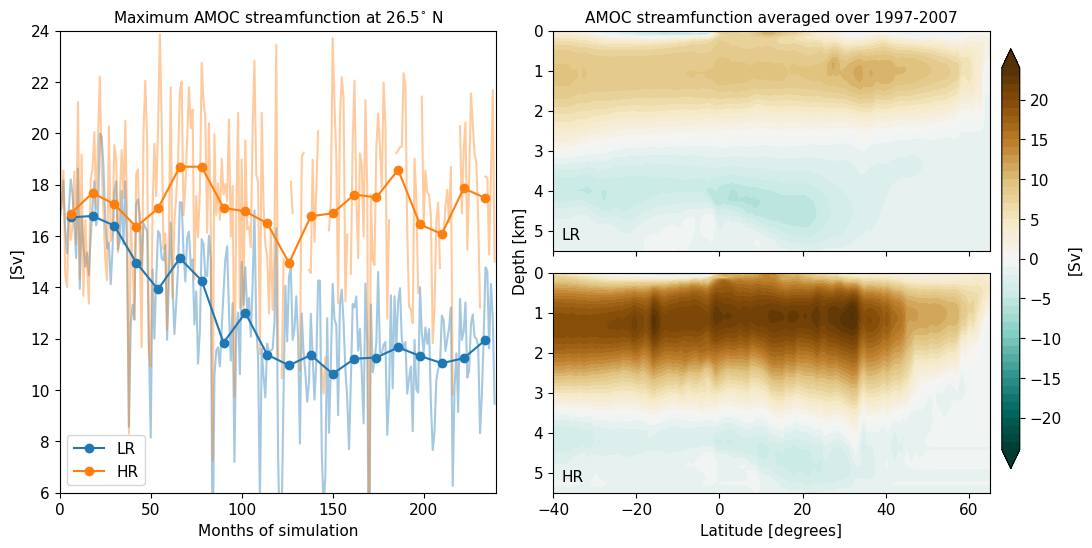

In [3]:
# Make figure layout
fig = plt.figure(figsize=(12, 6))
gs = plt.GridSpec(2, 2, hspace=0.1, wspace=0.13)
ax_left = fig.add_subplot(gs[:, 0])
axs = [fig.add_subplot(gs[row, 1]) for row in range(2)]

# Left panel timeseries
ax = ax_left
ax.set_xlim(0, 240)
ax.set_ylim(6, 24)
ax.set_xlabel('Months of simulation')
ax.set_ylabel('[Sv]')
ax.set_title('Maximum AMOC streamfunction at 26.5$^{\\circ}$ N')
palette = plt.get_cmap('tab10').colors
julys = np.arange(6, 240, 12)
decade = '1947-1957'
for meshName, color in zip(['LR', 'HR'], palette):
    y = []
    for decade in ['1947-1957', '1957-1967']:
        ilat = abs(MOC[meshName][decade]['lat'] - 26.5).argmin()
        y.append(MOC[meshName][decade]['MOC'][..., ilat].max(axis=1))
    y = np.hstack(y)
    y_ann = [np.nanmean(y[jul-6:jul+6]) for jul in julys]
    ax.plot(y, color=color, alpha=0.4, zorder=0)
    ax.plot(julys, y_ann, 'o-', color=color, label=meshName, zorder=1)
ax.legend(loc=3)

# Right panels AMOC
decade = '1997-2007'
for ax, meshName in zip(axs, ['LR', 'HR']):
    x, y, z = MOC[meshName][decade]['lat'], MOC[meshName]['refBottomDepth']*1e-3, MOC[meshName][decade]['MOC']
    c = ax.contourf(x, y, z.mean(axis=0), levels=np.arange(-24, 25), cmap='BrBG_r', extend='both')
    ax.set_xlim([-40, 65])
    ax.set_ylim(5.5, 0)
    ax.text(0.02, 0.05, meshName, transform=ax.transAxes)
axs[0].set_title(f'AMOC streamfunction averaged over {decade}')
axs[0].xaxis.set_ticklabels('')
axs[1].set_xlabel('Latitude [degrees]')
axs[1].set_ylabel('Depth [km]', y=1.1)
cax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
fig.colorbar(c, cax=cax, label='[Sv]')
#fig.savefig('/pscratch/sd/b/bmoorema/posterfigs/AMOC.pdf', bbox_inches='tight')

***

### Bias figures

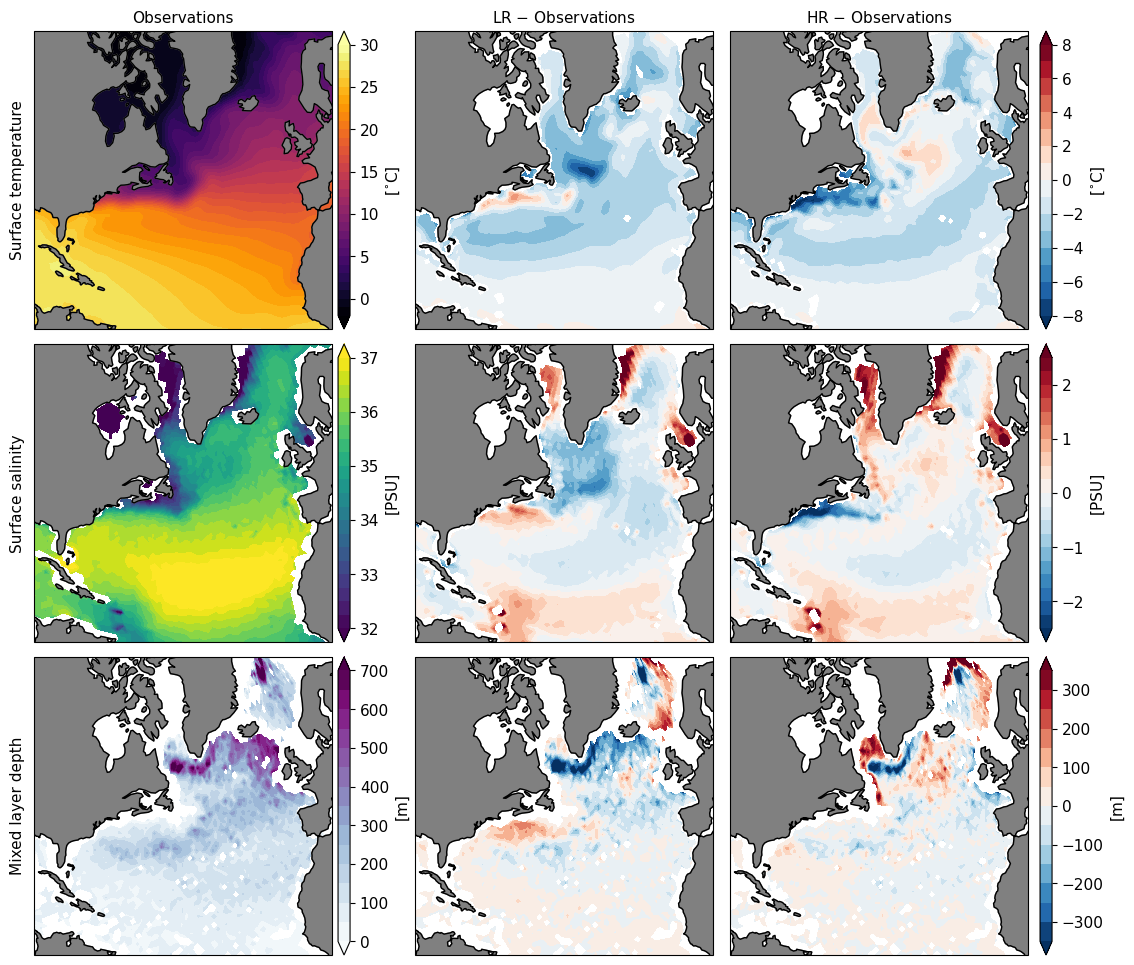

In [197]:
obspath = '/global/cfs/cdirs/e3sm/diagnostics/observations/Ocean/'
mpaspath = '/pscratch/sd/b/bmoorema/results/aggregated/lonlat/'

meshNames = ['EC30to60E2r2', 'oRRS18to6v3']
obsnames = ['SST', 'SSS', 'mld_dt_mean']
obsfilenames = [
    'SST/MODEL.SST.HAD187001-198110.OI198111-201203.nc',
    'SSS/Aquarius_V3_SSS_Monthly.nc',
    'MLD/holtetalley_mld_climatology.nc',
]
mpasnames = ['temperature', 'salinity', 'dThreshMLD']
plotnames = ['Surface temperature', 'Surface salinity', 'Mixed layer depth']
units = ['[$^{\\circ}$C]', '[PSU]', '[m]']
cmaps = ['inferno', 'viridis', 'BuPu']
clims = [(-2, 31, 1, 8), (32, 37.1, 0.25, 2.5), (0, 701, 50, 350)]
cticks = [(0, 31, 5, 8, 2), (32, 37.1, 1, 2, 1), (0, 701, 100, 300, 100)]

# Make map figure
decade = '19970101_20061231'
proj, proj_ref = crs.LambertConformal(-40, 40), crs.PlateCarree()
fig, axs = plt.subplots(3, 3, figsize=(12, 12), subplot_kw={'projection': proj}, gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
for ax, title in zip(axs[0, :], ['Observations', 'LR $-$ Observations', 'HR $-$ Observations']):
    ax.set_title(title)

iterables = [axs, obsnames, obsfilenames, mpasnames, cmaps, clims, cticks, units, plotnames]
for row, obsname, obsfilename, mpasname, cmap, clim, ctick, unit, plotname in zip(*iterables):
    
    filename = obspath + obsfilename
    with xr.open_dataset(filename) as ds:
        lons, lats = ds.lon.values, ds.lat.values
        variable_obs = ds[obsname]
    if obsname == 'SST':
        variable_obs = variable_obs.mean(dim='time').values #.sel(time=slice(*decade.split('_')))
        ilon = np.where(lons > 180)[0][0]
        variable_obs = np.hstack([variable_obs[:, ilon:], variable_obs[:, :ilon]])
        lons = np.hstack([lons[ilon:]-360, lons[:ilon]])
    elif obsname == 'mld_dt_mean':
        variable_obs = variable_obs.isel(iMONTH=[0, 1, 2]).mean(dim='iMONTH').values
    else:
        variable_obs = variable_obs.mean(dim='time').values
    c = row[0].contourf(lons, lats, variable_obs, cmap=cmap, levels=np.arange(*clim[:3]), extend='both', transform=proj_ref, zorder=-10)
    row[0].set_extent([-80, -12, 10, 78])
    row[0].coastlines()
    row[0].add_feature(feature.LAND, color='gray')
    pos = row[0].get_position()
    row[0].set_position([pos.x0-0.055, pos.y0, pos.width, pos.height])
    cax = fig.add_axes([pos.x1-0.05, pos.y0, 0.01, pos.height])
    fig.colorbar(c, cax=cax, label=unit, ticks=np.arange(*ctick[:3]))
    row[0].text(-0.08, 0.5, plotname, va='center', rotation=90, transform=row[0].transAxes)
    
    for ax, meshName in zip(row[1:], meshNames):

        filename = resultspath + f'20210421_sim7_CORE_{meshName}.mpas2Dtimeavg_wmt_{decade}.nc'
        levels = np.arange(-clim[3], clim[3]+clim[2], clim[2])
        with xr.open_dataset(filename) as ds:
            lon, lat = ds.lon.values, ds.lat.values
            variable = ds[mpasname]
        if 'depths' in variable.dims:
            variable = variable.isel(depths=0)
        if name == 'dThreshMLD':
            variable = variable.sel(months=variable.months.isin([12, 1, 2]))
        variable = variable.mean(dim='months', skipna='False')
        variable = variable.interp(lon=lons, lat=lats)
        c = ax.contourf(lons, lats, variable-variable_obs, cmap='RdBu_r', levels=levels, extend='both', transform=proj_ref)
        ax.set_extent([-80, -12, 10, 78])
        ax.coastlines()
        ax.add_feature(feature.LAND, color='gray')
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+0.01, pos.y0, 0.01, pos.height])
    fig.colorbar(c, cax=cax, label=unit, ticks=np.arange(-ctick[3], ctick[3]+ctick[4], ctick[4]))
fig.savefig('/pscratch/sd/b/bmoorema/posterfigs/biases.pdf', bbox_inches='tight')

### 2D transformation plots

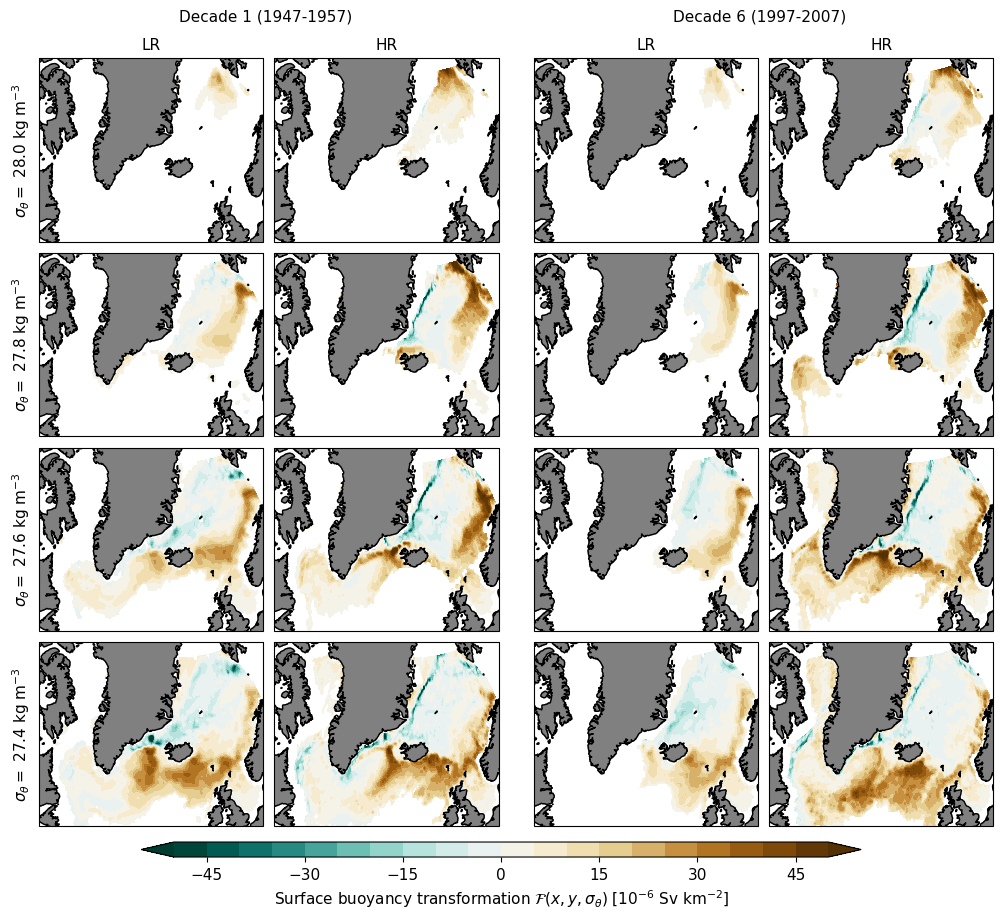

In [22]:
# Make map figure
decade = '19470101_19561231'
proj, proj_ref = crs.LambertConformal(-20, 70), crs.PlateCarree()
fig, axs = plt.subplots(4, 4, figsize=(12, 10), subplot_kw={'projection': proj}, gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}

meshes = ['EC30to60E2r2', 'oRRS18to6v3']
for panels, decade in zip([axs[:, :2], axs[:, 2:]], ['19470101_19561231', '19970101_20061231']):
    for col, mesh, meshName in zip(panels.T, meshes, ['LR', 'HR']):
        f = f'/pscratch/sd/b/bmoorema/results/aggregated/lonlat/20210421_sim7_CORE_{mesh}.mpas2Dtimeavg_wmt_{decade}.nc'
        ds = xr.open_dataset(f)
        col[0].set_title(meshName)
        for ax, sigmaBin in zip(col, [28, 27.8, 27.6, 27.4]):
            wmt = ds.totalTrans.sel(sigmaBins=sigmaBin).mean(dim='months')
            wmt = wmt.where(wmt!=0)
            c = ax.contourf(wmt.lon, wmt.lat, wmt, cmap='BrBG_r', levels=np.arange(-50, 51, 5), extend='both', transform=proj_ref)
            ax.set_extent([-60, 5, 50, 79])
            ax.coastlines(resolution='50m')
            ax.add_feature(feature.LAND, color='gray')
            pos = ax.get_position()
            if decade == '19470101_19561231':
                ax.set_position([pos.x0-0.01, pos.y0, pos.width, pos.height])
                if meshName == 'LR':
                    ax.text(-0.13, 0.5, f'$\\sigma_{{\\theta}} = $ {sigmaBin:0.1f} kg m$^{{-3}}$', va='center', rotation=90, transform=ax.transAxes)
            else:
                ax.set_position([pos.x0+0.01, pos.y0, pos.width, pos.height])

axs[0, 0].text(1.01, 1.2, 'Decade 1 (1947-1957)', ha='center', transform=axs[0, 0].transAxes)
axs[0, 2].text(1.01, 1.2, 'Decade 6 (1997-2007)', ha='center', transform=axs[0, 2].transAxes)
cax = fig.add_axes([0.2, 0.08, 0.6, 0.015])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Surface buoyancy transformation $\\mathcal{F}(x,y,\\sigma_{\\theta})$ [10$^{-6}$ Sv km$^{-2}$]')
fig.savefig('/pscratch/sd/b/bmoorema/posterfigs/transformation2D.pdf', bbox_inches='tight')

### Transect plots

In [38]:
meshName = 'LR'

# Get paths
with open(f'../yaml/paths_{meshName}.yaml') as f:
    paths = yaml.safe_load(f)

# Load coords
coords, transectMasks, subdomain = trtools.load_coords(paths)
index, sign = [transectMasks['Iceland-Scotland'][name] for name in ('index', 'sign')]
lonEdge, dvEdge = [coords[name][index] for name in ('lonEdge', 'dvEdge')]
ilon = np.argsort(lonEdge)
index, sign, dvEdge = [var[ilon] for var in (index, sign, dvEdge)]
lonVertex = coords['lonVertex']
cellsOnEdge, verticesOnEdge = [coords[name][index, :] for name in ('cellsOnEdge', 'verticesOnEdge')]
lons = [lonVertex[vertex].min() for vertex in verticesOnEdge]
lons.append(lonVertex[verticesOnEdge[-1, :]].max())
depths = np.insert(coords['depth'], 0, 0)

# Loop through decades
startyear = 1946
decade = (1947, 1957)

# Define results path
decade_str = str(decade[0]) + '-' + str(decade[1])
resultspath = paths['results'][decade_str] + '/' + paths['prefix']

# Define times
times = [datetime(year, month, 1) for year in range(*decade) for month in range(1, 13)]

In [39]:
# Loop through times
sigma, thickness, velocity = [], [], []
wmt, n = [], len(times)
for t in tqdm(times[:24]):

    # Load results
    filename = resultspath + f'.{t.year-startyear:04d}-{t.month:02d}-01.nc'
    with xr.open_dataset(filename) as ds:

        # Get sigma
        sigmaTheta = ds.timeMonthly_avg_potentialDensity[0, ...].values[subdomain, :] - 1000
        sigma.append(trtools.interpolate_to_edge(sigmaTheta, cellsOnEdge, subdomain))
        
        # Get layer thickness
        layerThickness = ds.timeMonthly_avg_layerThickness[0, ...].values[subdomain, :]
        thickness.append(trtools.interpolate_to_edge(layerThickness, cellsOnEdge, subdomain))
        
        # Get velocity
        velocity.append(ds.timeMonthly_avg_normalVelocity[0, index, :].values * sign[:, None])

100%|██████████| 24/24 [00:12<00:00,  1.97it/s]


In [40]:
sigma, thickness, velocity = [np.array(var).mean(axis=0).T for var in (sigma, thickness, velocity)]
mask = velocity == 0
sigma[mask], thickness[mask], velocity[mask] = np.nan, np.nan, np.nan
transport = velocity * thickness * dvEdge[None, :] * 1e-6
transect[meshName] = {
    'lons': lons, 'depths': depths, 'sigma': sigma, 'velocity': velocity, 'transport': transport,
}

In [41]:
def pcolor_threshold_polygons(x, y, z, threshold):
    """
    """

    # Build shapely polygons from sigma threshold
    rectangles = []
    for j, i in zip(*np.where(z >= threshold)):
        x0, x1, y0, y1 = x[i], x[i+1], y[j], y[j+1]
        rectangles.append(Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)]))
    polygons = unary_union(rectangles)

    # Shapely will return either a Polygon or a MultiPolygon. 
    # Make sure the structure is the same in any case.
    if polygons.geom_type == 'Polygon':
        polygons = [polygons]
    else:
        polygons = polygons.geoms
    
    return polygons

/tmp/ipykernel_2272340/706704443.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(c, cax=cax, label='Transect normal velocity [m s$^{-1}$]')


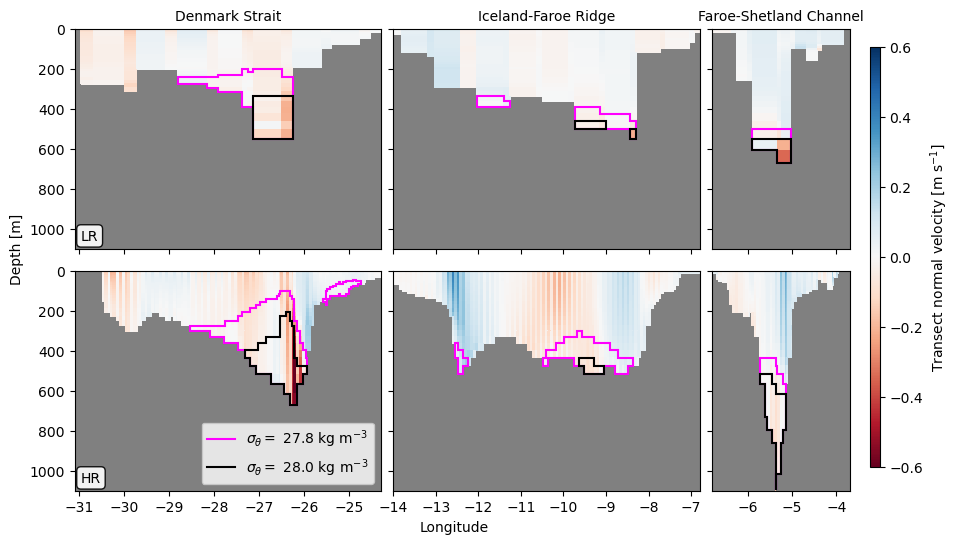

In [153]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6), gridspec_kw={'width_ratios': [1, 1, 0.45], 'wspace': 0.05, 'hspace': 0.1})
axs[1, 0].set_ylabel('Depth [m]', y=1.1)
axs[1, 1].set_xlabel('Longitude', x=0.2)
xlims, ylim = [(-31.1, -24.3), (-14, -6.8), (-6.8, -3.7)], [1100, 0]
names = ['Denmark Strait', 'Iceland-Faroe Ridge', 'Faroe-Shetland Channel']
props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}

for row, meshName in zip(axs, ['LR', 'HR']):
    lons, depths, sigma, velocity = [transect[meshName][name] for name in ('lons', 'depths', 'sigma', 'velocity')]
    polygons = {threshold: pcolor_threshold_polygons(lons, depths, sigma, threshold) for threshold in [27.8, 28]}
    for ax, xlim, name in zip(row, xlims, names):
        ax.add_patch(patches.Rectangle((xlim[0], ylim[0]), float(np.diff(xlim)), float(np.diff(ylim)), fc='gray'))
        c = ax.pcolor(lons, depths, velocity, cmap='RdBu', vmin=-0.6, vmax=0.6, shading='flat', lw=0.1)
        c.set_edgecolor('face')
        for threshold, color in zip([27.8, 28], ['magenta', 'k']):
            for polygon in polygons[threshold]:
                ax.add_patch(patches.Polygon(polygon.exterior.coords, fc='none', ec=color, lw=1.5))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_ticks(np.arange(*np.ceil(xlim)))

        if meshName == 'LR':
            ax.xaxis.set_ticklabels('')
            ax.set_title(name)
        if name == 'Denmark Strait':
            ax.text(0.02, 0.04, meshName, transform=ax.transAxes, bbox=props)
        else:
            ax.yaxis.set_ticklabels('')

# Colorbar
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='Transect normal velocity [m s$^{-1}$]')

# Fake legend
for threshold, color in zip([27.8, 28], ['magenta', 'k']):
    axs[1, 0].plot(0, 0, '-', color=color, label=f'$\\sigma_{{\\theta}} = $ {threshold:.1f} kg m$^{{-3}}$')
axs[1, 0].legend(loc=4)
fig.savefig('/pscratch/sd/b/bmoorema/paperfigs/GStransect_19471949.pdf', bbox_inches='tight')

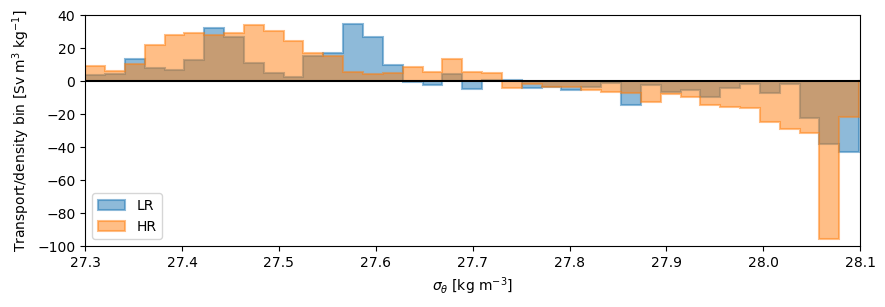

In [123]:
fig, ax = plt.subplots(figsize=(10, 3))
palette = plt.get_cmap('tab10').colors
xlim, ylim, binsize = [27.3, 28.14], [-100, 40], 0.02
bins = int(np.diff(xlim) / binsize)
for meshName, color, zorder in zip(['LR', 'HR'], palette, [1, 0]):
    sigma, transport = [transect[meshName][name] for name in ('sigma', 'transport')]
    _, _, _ = ax.hist(
        sigma.ravel(), range=xlim, bins=bins, weights=transport.ravel() / binsize,
        ec=color, alpha=0.5, lw=1.5, fill=True, histtype='step', label=meshName,
    )
ax.plot(xlim, [0, 0], 'k-')
ax.set_xlim([27.3, 28.1])
ax.set_ylim(ylim)
ax.set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
ax.set_ylabel('Transport/density bin [Sv m$^{3}$ kg$^{-1}$]')
ax.legend(loc=3)
fig.savefig('/pscratch/sd/b/bmoorema/paperfigs/GStransport_19471949.pdf', bbox_inches='tight')